## Load and split dataset

In [2]:
from skfp.datasets.lrgb import load_peptides_func
from skfp.model_selection import scaffold_train_test_split

dataset = load_peptides_func(as_frame=True)


In [3]:
smiles, toxicity = dataset["SMILES"], dataset["toxic"]
train_smiles, test_smiles, train_toxicity, test_toxicity = scaffold_train_test_split(
    smiles, toxicity, test_size=0.2
)

[16:07:07] WARNING: not removing hydrogen atom without neighbors
[16:07:07] WARNING: not removing hydrogen atom without neighbors


## Extract fingerprints using skfp and descriptors using mordred

In [13]:
from skfp.fingerprints import ECFPFingerprint

fp = ECFPFingerprint()
train_fingerprints = fp.transform(train_smiles, copy=True)
test_fingerprints = fp.transform(test_smiles, copy=True)

[16:16:05] WARNING: not removing hydrogen atom without neighbors
[16:16:05] WARNING: not removing hydrogen atom without neighbors


In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model on the training data
xgb_model.fit(train_fingerprints, train_toxicity)

# Predict toxicity on the test data
predictions = xgb_model.predict(test_fingerprints)

# Evaluate the model
xgb_report = classification_report(test_toxicity, predictions)
print("XGBoost Classification Report:")
print(xgb_report)

/Users/wojciechbarczynski/agh/sem1/data_mining/toxicity_prediction/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:16:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.87      2153
           1       0.74      0.56      0.64       954

    accuracy                           0.80      3107
   macro avg       0.78      0.74      0.75      3107
weighted avg       0.80      0.80      0.80      3107



In [ ]:
import optuna
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# Split the training set into training and validation sets
train_fingerprints_split, val_fingerprints, train_toxicity_split, val_toxicity = train_test_split(
    train_fingerprints, train_toxicity, test_size=0.2, random_state=42
)

# Create LightGBM datasets
train_data_split = lgb.Dataset(train_fingerprints_split, label=train_toxicity_split, params={'feature_pre_filter': False})
val_data = lgb.Dataset(val_fingerprints, label=val_toxicity, params={'feature_pre_filter': False})

def objective(trial):
    # Define the hyperparameters to tune
    params = {
        'objective': 'binary',
        'metric': 'binary_error',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
    }

    # Train the LightGBM model
    lgb_model = lgb.train(params, train_data_split, num_boost_round=100, valid_sets=[val_data])

    # Predict toxicity on the validation data
    val_predictions = (lgb_model.predict(val_fingerprints) > 0.5).astype(int)

    # Evaluate the model
    accuracy = accuracy_score(val_toxicity, val_predictions)
    return accuracy

# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print("Best parameters:", study.best_params)

# Train the final model with the best parameters
best_params = study.best_params
best_params['objective'] = 'binary'
best_params['metric'] = 'binary_error'
lgb_model = lgb.train(best_params, train_data_split, num_boost_round=100)

# Predict and evaluate on the test set
lgb_predictions = (lgb_model.predict(test_fingerprints) > 0.5).astype(int)
lgb_report = classification_report(test_toxicity, lgb_predictions)
# Clean output because LightGBM + optuna prints a lot of information

In [25]:
print("LightGBM Classification Report with Optimized Parameters:")
print(lgb_report)

LightGBM Classification Report with Optimized Parameters:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2153
           1       0.77      0.57      0.65       954

    accuracy                           0.81      3107
   macro avg       0.80      0.75      0.76      3107
weighted avg       0.81      0.81      0.81      3107



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Split the training set into training and validation sets
train_fingerprints_split, val_fingerprints, train_toxicity_split, val_toxicity = train_test_split(
    train_fingerprints, train_toxicity, test_size=0.2, random_state=42
)

def knn_objective(trial):
    # Define the hyperparameters to tune
    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])

    # Initialize the KNN classifier
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)

    # Train the model
    knn_model.fit(train_fingerprints_split, train_toxicity_split)

    # Predict on the validation set
    val_predictions = knn_model.predict(val_fingerprints)

    # Evaluate the model
    accuracy = accuracy_score(val_toxicity, val_predictions)
    return accuracy

# Create a study and optimize
knn_study = optuna.create_study(direction='maximize')
knn_study.optimize(knn_objective, n_trials=50)

# Print the best parameters
print("Best parameters for KNN:", knn_study.best_params)

# Train the final KNN model with the best parameters
best_knn_params = knn_study.best_params
knn_model = KNeighborsClassifier(**best_knn_params)
knn_model.fit(train_fingerprints, train_toxicity)

# Predict and evaluate on the test set
knn_predictions = knn_model.predict(test_fingerprints)
knn_report = classification_report(test_toxicity, knn_predictions)
# Clean output because KNN + optuna prints a lot of information

In [27]:
print("KNN Classification Report with Optimized Parameters:")
print(knn_report)

KNN Classification Report with Optimized Parameters:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      2153
           1       0.66      0.54      0.60       954

    accuracy                           0.78      3107
   macro avg       0.74      0.71      0.72      3107
weighted avg       0.77      0.78      0.77      3107



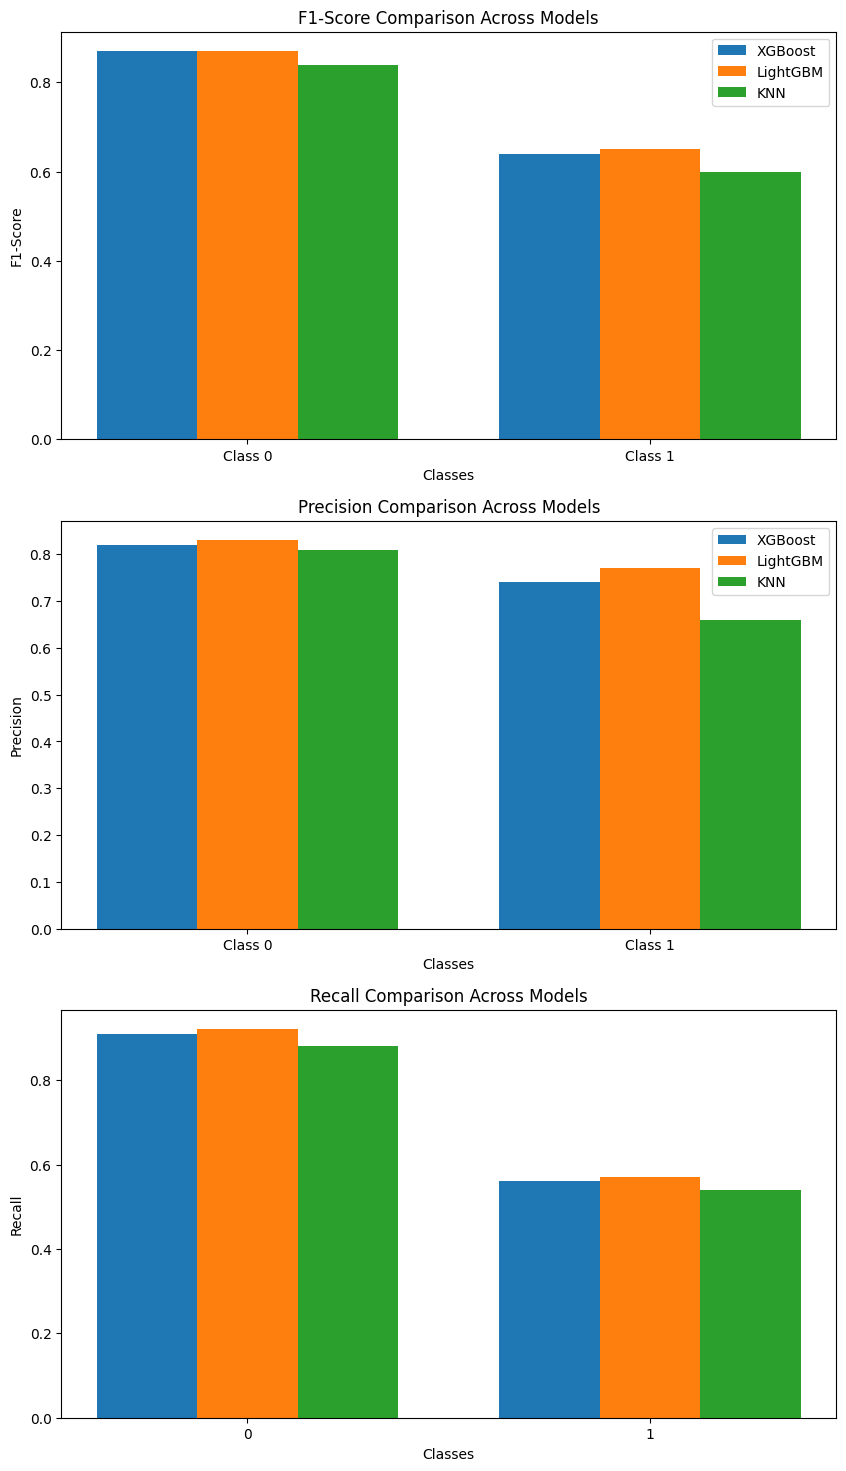

In [29]:
import matplotlib.pyplot as plt

# Parse metrics from classification reports
def parse_metrics(report):
    lines = report.split('\n')
    metrics = {'precision': [], 'recall': [], 'f1-score': []}
    for line in lines[2:4]:  # Extract metrics for Class 0 and Class 1
        values = line.split()
        metrics['precision'].append(float(values[1]))
        metrics['recall'].append(float(values[2]))
        metrics['f1-score'].append(float(values[3]))
    return metrics

xgb_metrics = parse_metrics(xgb_report)
lgb_metrics = parse_metrics(lgb_report)
knn_metrics = parse_metrics(knn_report)

# Plot metrics
labels = ['Class 0', 'Class 1']
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(3, 1, figsize=(10, 18))

# Plot F1-score
ax[0].bar(x - width, xgb_metrics['f1-score'], width, label='XGBoost')
ax[0].bar(x, lgb_metrics['f1-score'], width, label='LightGBM')
ax[0].bar(x + width, knn_metrics['f1-score'], width, label='KNN')
ax[0].set_xlabel('Classes')
ax[0].set_ylabel('F1-Score')
ax[0].set_title('F1-Score Comparison Across Models')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

# Plot Precision
ax[1].bar(x - width, xgb_metrics['precision'], width, label='XGBoost')
ax[1].bar(x, lgb_metrics['precision'], width, label='LightGBM')
ax[1].bar(x + width, knn_metrics['precision'], width, label='KNN')
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision Comparison Across Models')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

# Plot Recall
ax[2].bar(x - width, xgb_metrics['recall'], width, label='XGBoost')
ax[2].bar(x, lgb_metrics['recall'], width, label='LightGBM')
ax[2].bar(x + width, knn_metrics['recall'], width, label='KNN')
ax[2].set_xlabel('Classes')
ax[2].set_ylabel('Recall')
ax[2].set_title('Recall Comparison Across Models')
ax[2].set_xticks(x)